<a href="https://colab.research.google.com/github/Przemo200/Red_Wines_Classification/blob/main/WineClassesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red wine quality classification
**Goal -** to predict whether a red wine is "good" or "bad" quality based on physicochemical tests

**Methodology -** I will perform EDA, feature engineering and train an optimized **XGBoost** model.
Finally, I will use **SHAP** values to explain the model's decisions

### 1. Environment setup
Importing necessary libraries and configuring the plotting style

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# config plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("Libraries loaded")

Libraries loaded


### 2. Data loading and cleaning
Downloading the dataset from Kaggle, removing duplicates and standardizing column names

In [2]:
# dataset
path = kagglehub.dataset_download("uciml/red-wine-quality-cortez-et-al-2009")
csv_path = os.path.join(path, "winequality-red.csv")

df = pd.read_csv(csv_path)

df.drop_duplicates(inplace=True)
df.columns = [col.capitalize() for col in df.columns]
df.rename(columns={"Ph": "pH"}, inplace=True)

# binary target of good or bad wine
df["Label quality"] = df["Quality"].apply(lambda x: 0 if x <= 5 else 1)

print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'red-wine-quality-cortez-et-al-2009' dataset.
Data shape: (1359, 13)


,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free sulfur dioxide,Total sulfur dioxide,Density,pH,Sulphates,Alcohol,Quality,Label quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0


### 3. EDA - overview
Checking data structure, descriptive statistics and missing values

In [3]:
df.info()
display(df.describe().T)

print(f"\nMissing values:\n{df.isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fixed acidity         1359 non-null   float64
 1   Volatile acidity      1359 non-null   float64
 2   Citric acid           1359 non-null   float64
 3   Residual sugar        1359 non-null   float64
 4   Chlorides             1359 non-null   float64
 5   Free sulfur dioxide   1359 non-null   float64
 6   Total sulfur dioxide  1359 non-null   float64
 7   Density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   Sulphates             1359 non-null   float64
 10  Alcohol               1359 non-null   float64
 11  Quality               1359 non-null   int64  
 12  Label quality         1359 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 148.6 KB


,count,mean,std,min,25%,50%,75%,max
Fixed acidity,1359.0,8.310596,1.736990,4.60000,7.1000,7.9000,9.20000,15.90000
Volatile acidity,1359.0,0.529478,0.183031,0.12000,0.3900,0.5200,0.64000,1.58000
Citric acid,1359.0,0.272333,0.195537,0.00000,0.0900,0.2600,0.43000,1.00000
Residual sugar,1359.0,2.523400,1.352314,0.90000,1.9000,2.2000,2.60000,15.50000
Chlorides,1359.0,0.088124,0.049377,0.01200,0.0700,0.0790,0.09100,0.61100
Free sulfur dioxide,1359.0,15.893304,10.447270,1.00000,7.0000,14.0000,21.00000,72.00000
Total sulfur dioxide,1359.0,46.825975,33.408946,6.00000,22.0000,38.0000,63.00000,289.00000
Density,1359.0,0.996709,0.001869,0.99007,0.9956,0.9967,0.99782,1.00369
pH,1359.0,3.309787,0.155036,2.74000,3.2100,3.3100,3.40000,4.01000
Sulphates,1359.0,0.658705,0.170667,0.33000,0.5500,0.6200,0.73000,2.00000



Missing values:
Fixed acidity           0
Volatile acidity        0
Citric acid             0
Residual sugar          0
Chlorides               0
Free sulfur dioxide     0
Total sulfur dioxide    0
Density                 0
pH                      0
Sulphates               0
Alcohol                 0
Quality                 0
Label quality           0
dtype: int64


### 4. Data visualization
Visualizing feature distributions and the balance between good and bad wine classes

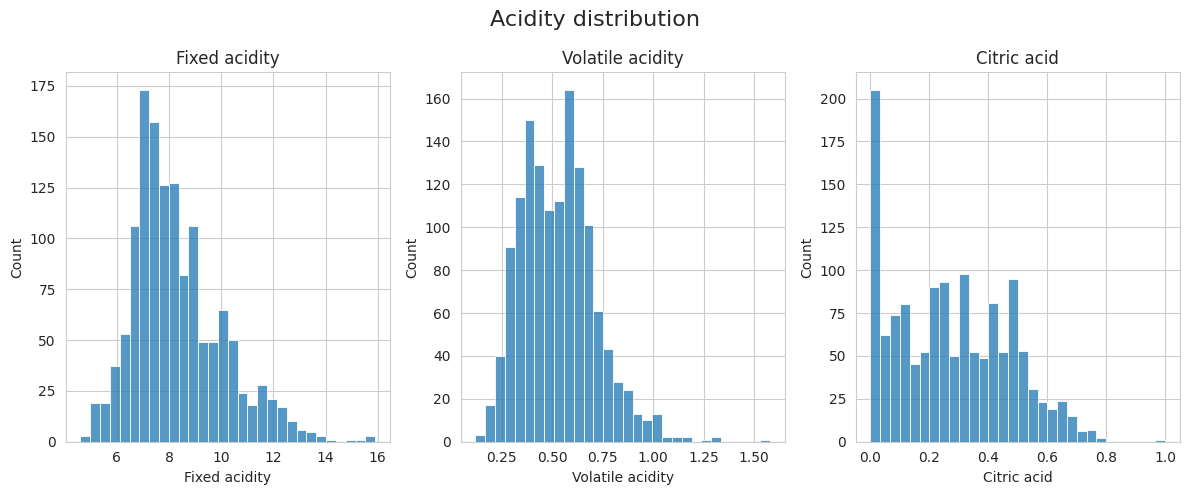

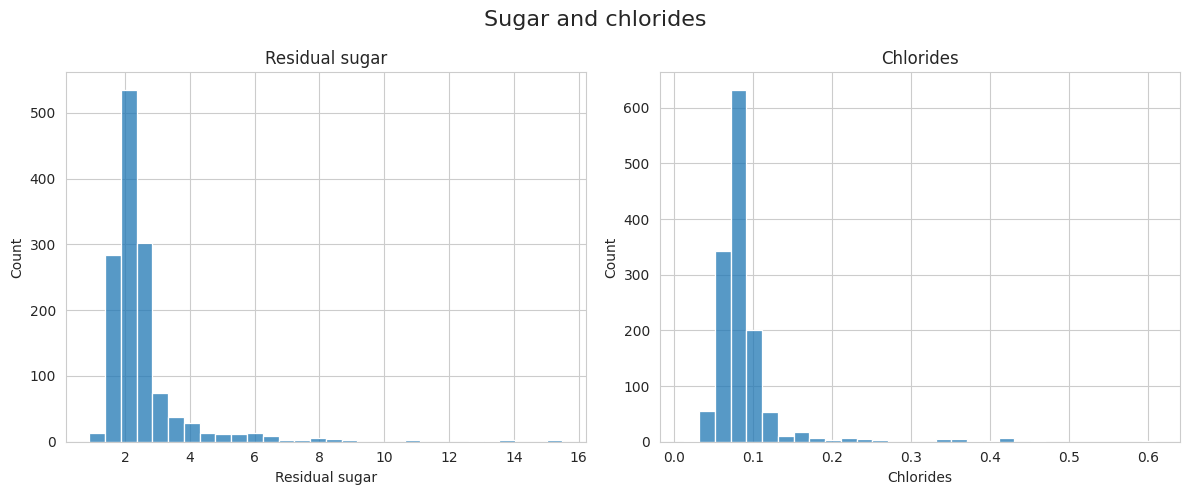

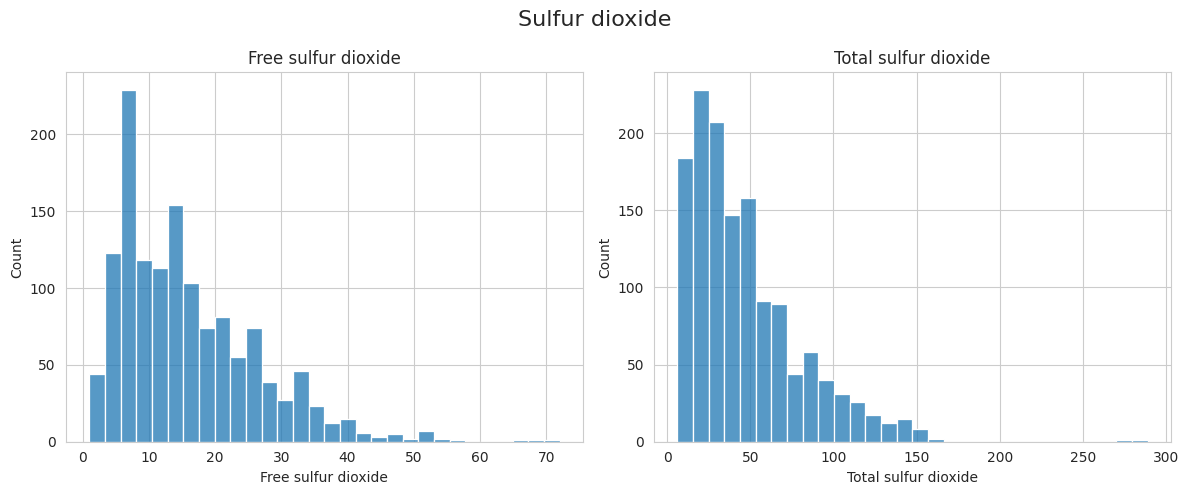

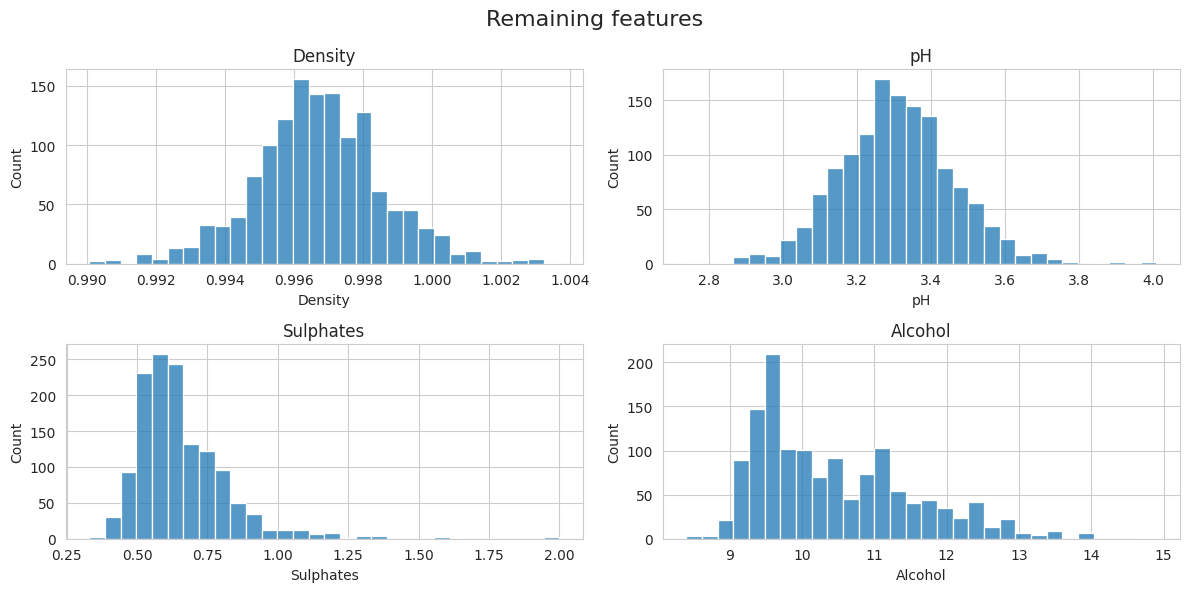

In [4]:
# acidity features
plt.figure(figsize=(12, 5))
plt.suptitle("Acidity distribution", fontsize=16)
plt.subplot(1, 3, 1); sns.histplot(df["Fixed acidity"], bins=30); plt.title("Fixed acidity")
plt.subplot(1, 3, 2); sns.histplot(df["Volatile acidity"], bins=30); plt.title("Volatile acidity")
plt.subplot(1, 3, 3); sns.histplot(df["Citric acid"], bins=30); plt.title("Citric acid")
plt.tight_layout(); plt.show()

# sugar and chlorides
plt.figure(figsize=(12, 5))
plt.suptitle("Sugar and chlorides", fontsize=16)
plt.subplot(1, 2, 1); sns.histplot(df["Residual sugar"], bins=30); plt.title("Residual sugar")
plt.subplot(1, 2, 2); sns.histplot(df["Chlorides"], bins=30); plt.title("Chlorides")
plt.tight_layout(); plt.show()

# sulfur dioxide
plt.figure(figsize=(12, 5))
plt.suptitle("Sulfur dioxide", fontsize=16)
plt.subplot(1, 2, 1); sns.histplot(df["Free sulfur dioxide"], bins=30); plt.title("Free sulfur dioxide")
plt.subplot(1, 2, 2); sns.histplot(df["Total sulfur dioxide"], bins=30); plt.title("Total sulfur dioxide")
plt.tight_layout(); plt.show()

# other features
plt.figure(figsize=(12, 6))
plt.suptitle("Remaining features", fontsize=16)
plt.subplot(2, 2, 1); sns.histplot(df["Density"], bins=30); plt.title("Density")
plt.subplot(2, 2, 2); sns.histplot(df["pH"], bins=30); plt.title("pH")
plt.subplot(2, 2, 3); sns.histplot(df["Sulphates"], bins=30); plt.title("Sulphates")
plt.subplot(2, 2, 4); sns.histplot(df["Alcohol"], bins=30); plt.title("Alcohol")
plt.tight_layout(); plt.show()

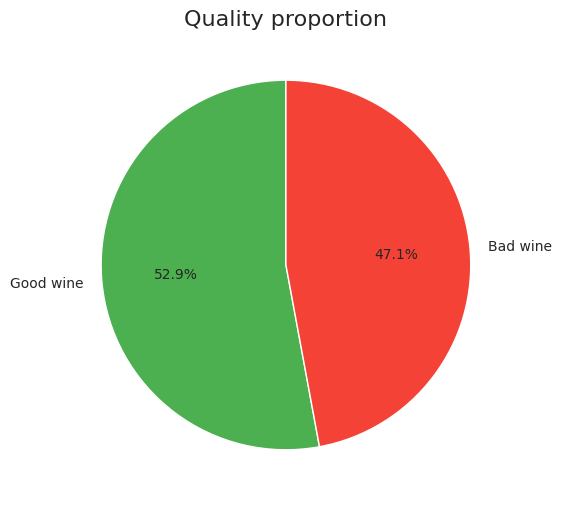

In [5]:
# define labels
labels = ['Good wine', 'Bad wine']
sizes = [df["Label quality"].value_counts()[1], df["Label quality"].value_counts()[0]]
colors = ['#4CAF50', '#F44336']

# plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Quality proportion", fontsize=16)
plt.show()

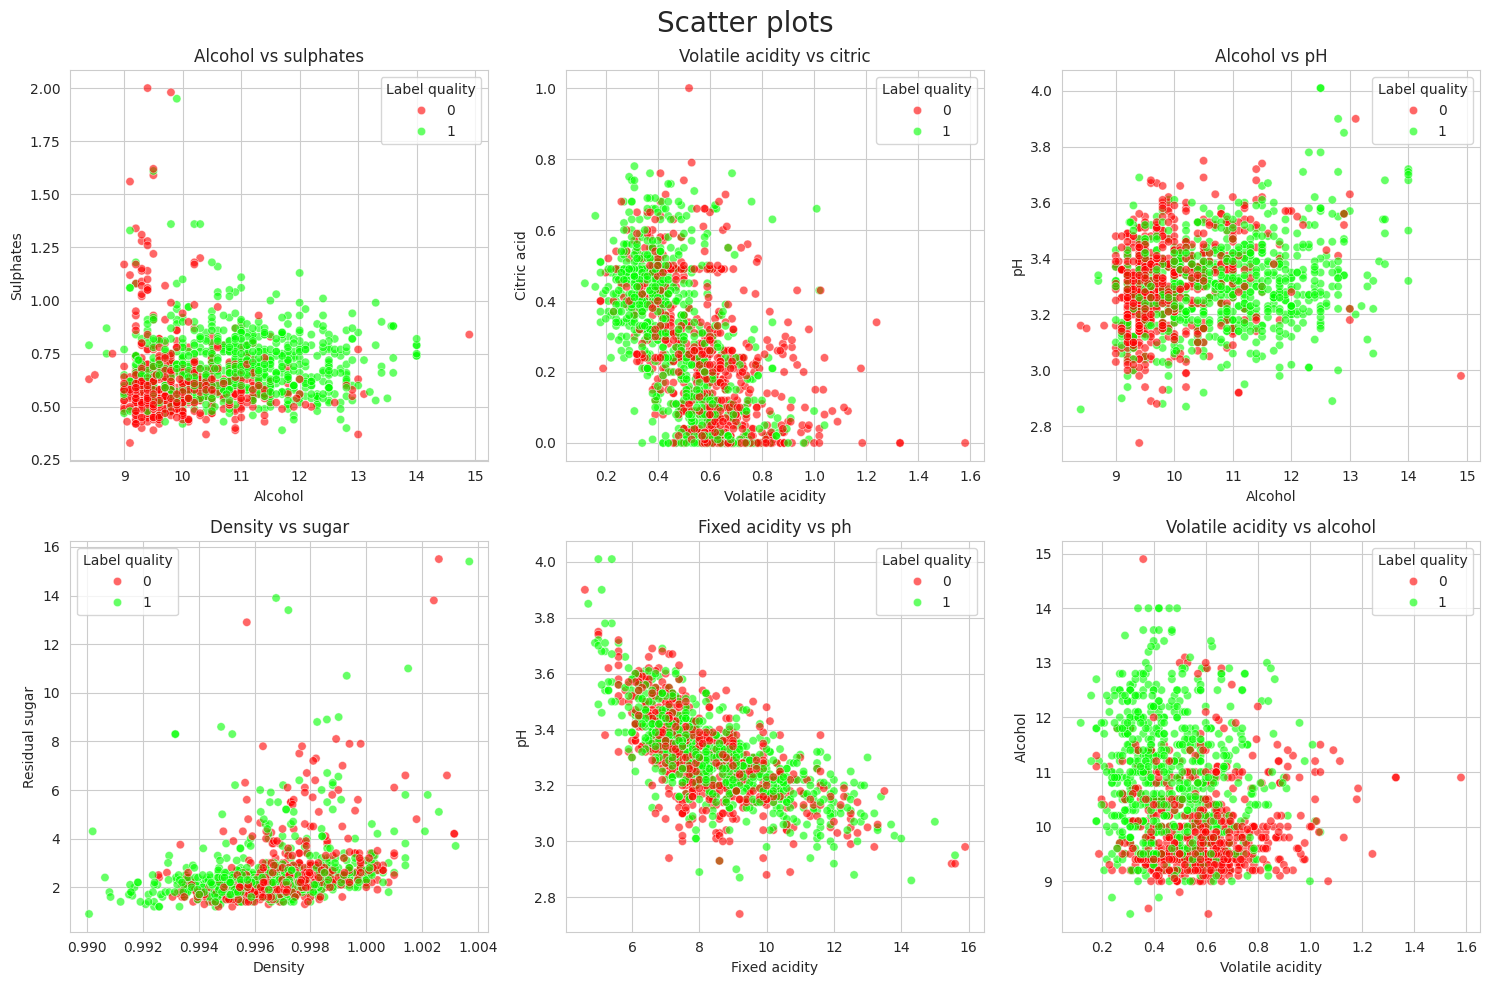

In [6]:
colors_palette = ["#FF0000", "#00FF00"]

plt.figure(figsize=(15, 10))
plt.suptitle("Scatter plots", fontsize=20)

# plot multivariate relations
plt.subplot(2, 3, 1)
sns.scatterplot(data=df, x="Alcohol", y="Sulphates", hue="Label quality", palette=colors_palette, alpha=0.6)
plt.title("Alcohol vs sulphates")

plt.subplot(2, 3, 2)
sns.scatterplot(data=df, x="Volatile acidity", y="Citric acid", hue="Label quality", palette=colors_palette, alpha=0.6)
plt.title("Volatile acidity vs citric")

plt.subplot(2, 3, 3)
sns.scatterplot(data=df, x="Alcohol", y="pH", hue="Label quality", palette=colors_palette, alpha=0.6)
plt.title("Alcohol vs pH")

plt.subplot(2, 3, 4)
sns.scatterplot(data=df, x="Density", y="Residual sugar", hue="Label quality", palette=colors_palette, alpha=0.6)
plt.title("Density vs sugar")

plt.subplot(2, 3, 5)
sns.scatterplot(data=df, x="Fixed acidity", y="pH", hue="Label quality", palette=colors_palette, alpha=0.6)
plt.title("Fixed acidity vs ph")

plt.subplot(2, 3, 6)
sns.scatterplot(data=df, x="Volatile acidity", y="Alcohol", hue="Label quality", palette=colors_palette, alpha=0.6)
plt.title("Volatile acidity vs alcohol")

plt.tight_layout()
plt.show()

### 5. Feature engineering
Creating new chemical features to improve model performance

In [7]:
# total acidity sum
df['Total acidity'] = df['Fixed acidity'] + df['Volatile acidity']

# prevent zero division
df['Sulfur ratio'] = df['Free sulfur dioxide'] / (df['Total sulfur dioxide'] + 1e-6)

# sugar acid ratio
df['Sugar/Acid ratio'] = df['Residual sugar'] / (df['Fixed acidity'] + 1e-6)

# alcohol ph ratio
df['Alcohol/pH ratio'] = df['Alcohol'] / (df['pH'] + 1e-6)

print("New features created")
df[['Total acidity', 'Sulfur ratio', 'Sugar/Acid ratio', 'Label quality']].head()

New features created


,Total acidity,Sulfur ratio,Sugar/Acid ratio,Label quality
0,8.10,0.323529,0.256757,0
1,8.68,0.373134,0.333333,0
2,8.56,0.277778,0.294872,0
3,11.48,0.283333,0.169643,1
5,8.06,0.325000,0.243243,0


### 6. Correlation analysis
Checking relationships between features, including the newly created variables

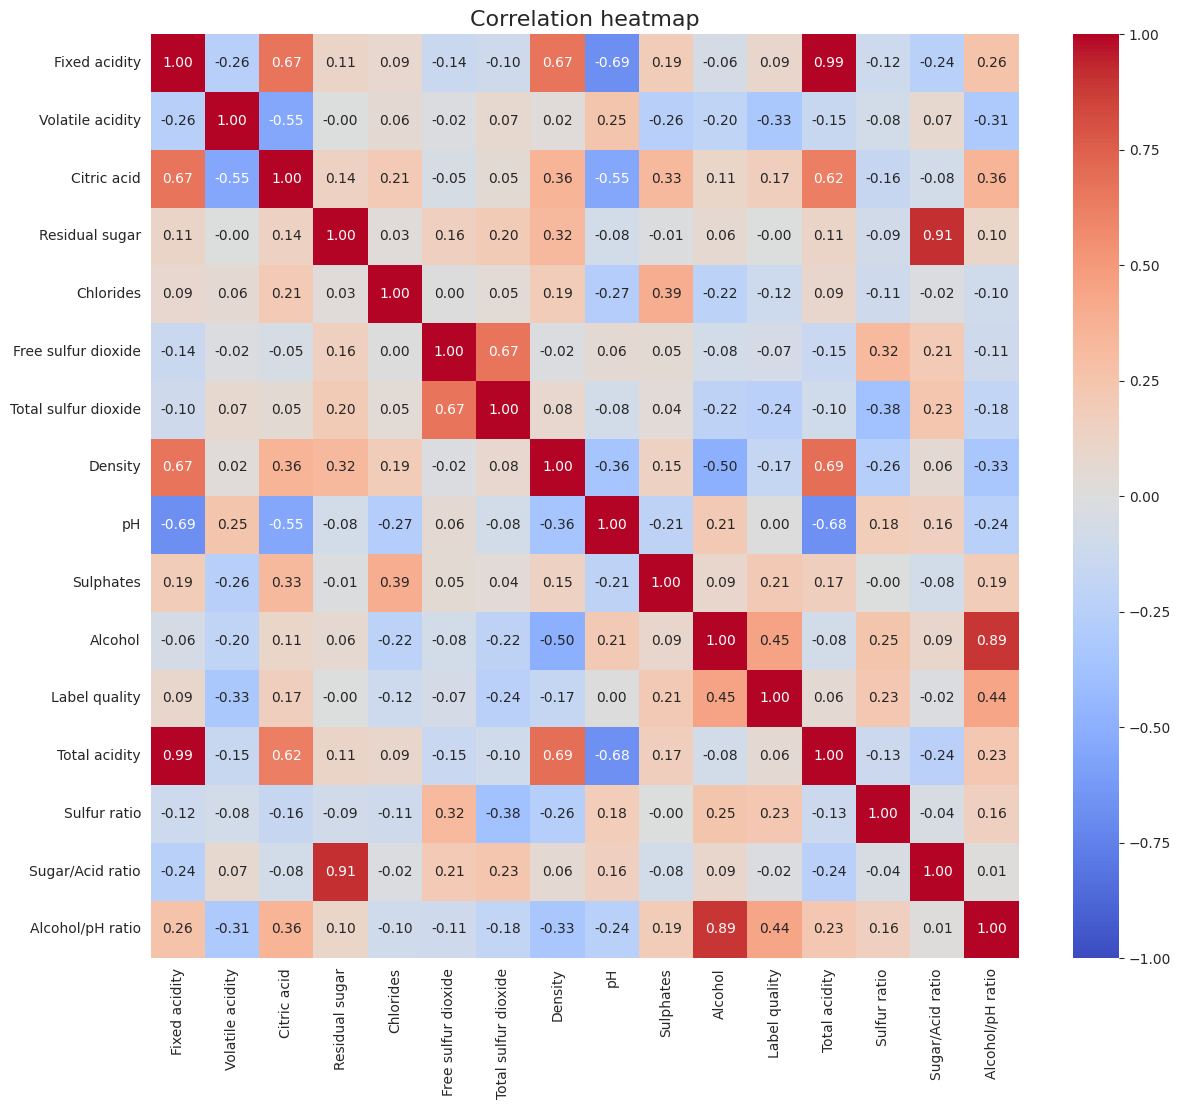

In [8]:
# no target column in heatmap
corr_df = df.drop(columns=["Quality"])

# plot of heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation heatmap', fontsize=16)
plt.show()

### 7. Data preprocessing
Splitting the data into training and test set and scaling features using StandardScaler

In [9]:
# features and target
X = df.drop(columns=["Quality", "Label quality"])
y = df["Label quality"]

# stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"Train shape: {X_train.shape}, test shape: {X_test.shape}")

Train shape: (1087, 15), test shape: (272, 15)


### 8. Model training and tuning
Optimizing **XGBoost** hyperparameters using RandomizedSearchCV to find the best config

In [10]:
print("Starting hyperparameter search...")

# base model
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

# randomized search cv
search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_scaled, y_train)
best_model = search.best_estimator_

print(f"Best parameters: {search.best_params_}")
print(f"Best f1 score: {search.best_score_:.4f}")

Starting hyperparameter search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [19:01:35] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best f1 score: 0.7516


### 9. Model evaluation
Assessing performance on the test set using accuracy, F1-Score and confusion aatrix

Accuracy: 0.7610
F1 score: 0.7605

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75       128
           1       0.78      0.76      0.77       144

    accuracy                           0.76       272
   macro avg       0.76      0.76      0.76       272
weighted avg       0.76      0.76      0.76       272



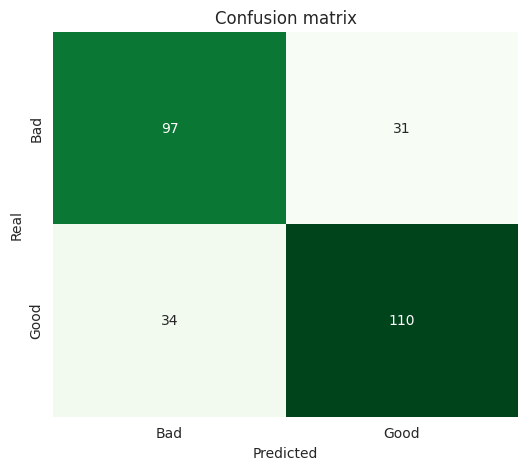

In [11]:
# predict test set
y_pred = best_model.predict(X_test_scaled)

# calculate metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

# plot confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion matrix')
plt.show()

### 10. Explainability by SHAP
Using SHAP values to understand global feature importance and explain individual predictions

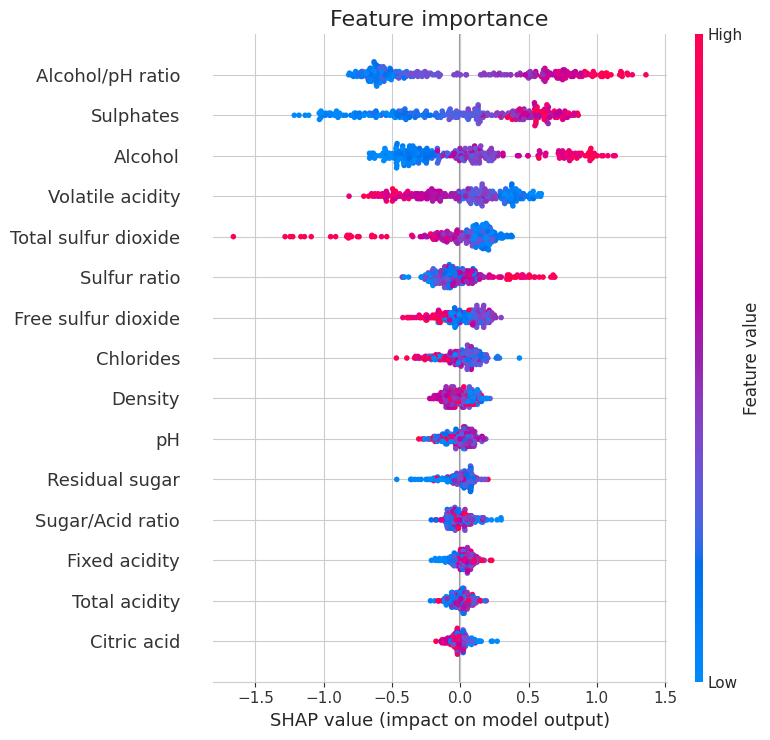

Analyzing wine index: 2


 98%|===================| 266/272 [00:14<00:00]       

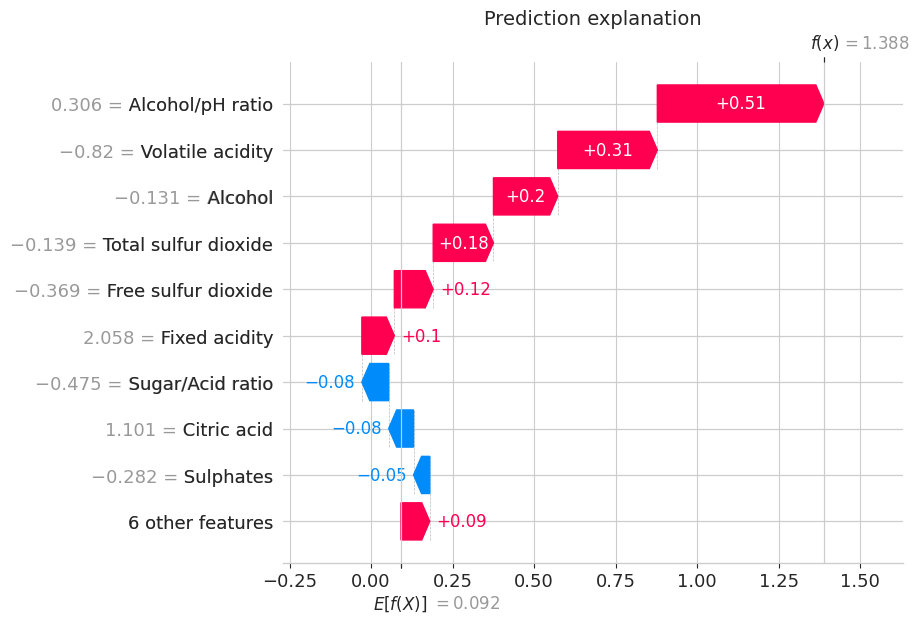

In [13]:
# calculate shap values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

# summary plot
plt.figure(figsize=(10, 8))
plt.title("Feature importance", fontsize=16)
shap.summary_plot(shap_values, X_test_scaled, show=False)
plt.show()

# select random good wine
good_wine_indices = np.where(y_pred == 1)[0]
sample_idx = good_wine_indices[0]

print(f"Analyzing wine index: {sample_idx}")

# waterfall plot
explainer_obj = shap.Explainer(best_model, X_test_scaled)
shap_values_obj = explainer_obj(X_test_scaled)

plt.title(f"Prediction explanation", fontsize=14)
shap.plots.waterfall(shap_values_obj[sample_idx], max_display=10)

## Conclusions

1.  **Model performance -** the optimized XGBoost model achieved a solid F1-score, effectively distinguishing between good and bad wines
2.  **Key features -** according to SHAP analysis, the most important factors influencing wine quality are:
    * **Alcohol -** higher alcohol content generally correlates with better quality
    * **Sulphates -** act as an antioxidant. Optimal levels positively impact the rating
    * **Volatile acidity -** high levels - vinegar-like taste - strongly decrease the quality
3.  **Feature engineering -** adding domain-specific features like `Total acidity` and `Sulfur ratio` helped the model capture complex chemical relationships